In [ ]:
"""
Created on Sun June  7 20:54:36 2020
@author: Sm
"""

'\nCreated on Sun June  7 20:54:36 2020\n@author: Sm\n'

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class Tweet(object):
    def __init__(self, content, polarity):
        self.content = content
        self.polarity = polarity

In [ ]:
#!pip3 install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Stock investment recommendations based on Machine Learning predictions from last year's values of any market symbol 
# and also based on Twitter sentiment analysis from retrieved tweets containing the symbol as text inside of it.
#!pip3 install tweepy
#!pip3 install textblob
#!pip3 install tweet
#!pip3 install fix_yahoo_finance
#!pip3 install constants
#!pip3 install nsepy
import datetime as dt
import math

import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tweepy
from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from textblob import TextBlob
# import nsepy

style.use('ggplot')

In [ ]:
consumer_key = 'fICIFmImYjp8Bvv7YoHHFe08G'
consumer_secret = 'DwOHmSgPje3QSFcJCj8uiqyVCRuLzvXe7cwGb1CGu4LDcCncfw'
access_token = '1249705548724842497-zFKFrZrHAqZiEP0ImPrubYhO9Ztrqw'
access_token_secret = 'XUYDqOb0JARbTVGM7TNsY0adSSXDJKlU0w48BO3bPvJSH'

num_of_tweets = 1000

In [ ]:
'''
To check if the stock symbol introduced via prompt is valid (or if it exists), we can check it using 'companylist.csv'.
'''
def check_stock_symbol(flag=False, companies_file='companylist.csv'):
    df = pd.read_csv('gdrive/My Drive/DATA/company_list/companylist.csv', usecols=[0])
    dfind = pd.read_csv('gdrive/My Drive/DATA/company_list/ind_nifty500list.csv')
    while flag is False:
        symbol = input('Enter a stock symbol to retrieve data from: ').upper()
        if symbol in df['Symbol']:
          print('yes')
        for index in range(len(df)):
            if df['Symbol'][index] == symbol:
                flag = True
        for index in range(len(dfind)):
          if dfind['Symbol'][index] == symbol:
            flag = True
    return flag, symbol


In [ ]:
'''
Now, the next step is to create the Pandas DataFrame of the introduced symbol stock market values from the last year from now
'''
def get_stock_data(symbol, from_date, to_date):
    data = yf.download(symbol, start=from_date, end=to_date)
    df = pd.DataFrame(data=data)

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df['HighLoad'] = (df['High'] - df['Close']) / df['Close'] * 100.0
    df['Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Close', 'HighLoad', 'Change', 'Volume']]
    return df

In [ ]:
''' Splitting the Dataset and using Linear Regression to predict'''
def stock_forecasting(df):
    forecast_col = 'Close'
    forecast_out = int(math.ceil(0.1*len(df)))
    df['Label'] = df[[forecast_col]].shift(-forecast_out)

    X = np.array(df.drop(['Label'], axis=1))
    X = preprocessing.scale(X)
    X_forecast = X[-forecast_out:]
    X = X[:-forecast_out]

    df.dropna(inplace=True)
    y = np.array(df['Label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    forecast = clf.predict(X_forecast)

    df['Prediction'] = np.nan

    last_date = df.iloc[-1].name
    last_date = dt.datetime.strptime(str(last_date), "%Y-%m-%d %H:%M:%S")

    for pred in forecast:
        last_date += dt.timedelta(days=1)
        df.loc[last_date.strftime("%Y-%m-%d")] = [np.nan for _ in range(len(df.columns) - 1)] + [pred]
    return df, forecast_out

In [ ]:
def forecast_plot(df):
    plt.figure(figsize=(40,15))
    df['Close'].plot(color='black')
    df['Prediction'].plot(color='green')
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()


In [ ]:
'''
 the Twitter sentiment analysis starts and it retrieves a list of the last 10000 tweets posted in english containing the
  symbol introduced and they are later stored in a list of Tweet class, defined in Tweet.py with the tweet's text and polarity 
  from TextBlob.  '''
def retrieving_tweets_polarity(symbol):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    user = tweepy.API(auth)
    tweets = tweepy.Cursor(user.search, q=str(symbol), tweet_mode='extended', lang='en').items(num_of_tweets)

    tweet_list = []
    global_polarity = 0
    for tweet in tweets:
        tw = tweet.full_text
        blob = TextBlob(tw)
        polarity = 0
        for sentence in blob.sentences:
            polarity += sentence.sentiment.polarity
            global_polarity += sentence.sentiment.polarity
        tweet_list.append(Tweet(tw, polarity))

    global_polarity = global_polarity / len(tweet_list)
    return global_polarity

In [ ]:
def recommending(df, forecast_out, global_polarity):
    if df.iloc[-forecast_out-1]['Close'] < df.iloc[-1]['Prediction']:
        if global_polarity > 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a GREAT idea!" % str(symbol))
        elif global_polarity < 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))
    else:
        print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))


Enter a stock symbol to retrieve data from: GOGL
Retrieving Stock Data from introduced symbol...
[*********************100%***********************]  1 of 1 downloaded
Forecasting stock DataFrame...
Plotting existing and forecasted values...


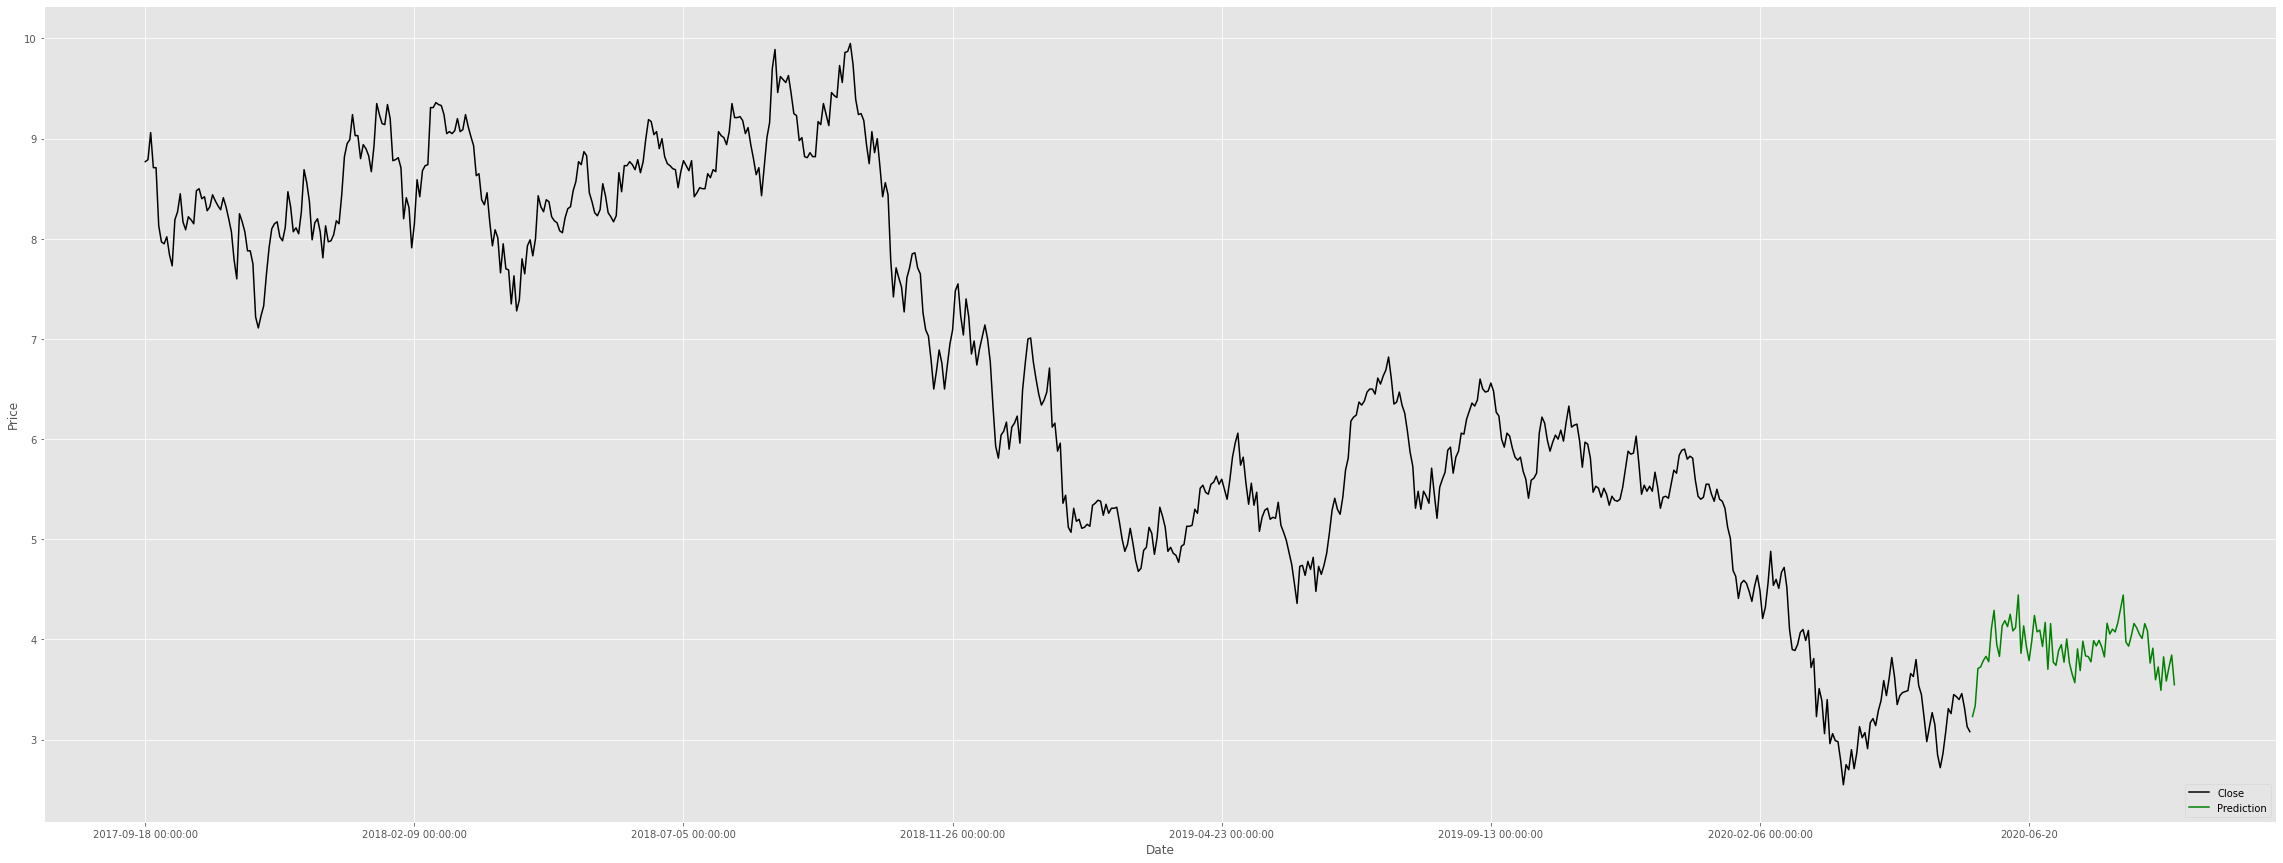

Retrieving GOGL related tweets polarity...
Generating recommendation based on prediction & polarity...
According to the predictions and twitter sentiment analysis -> Investing in GOGL is a GREAT idea!


In [ ]:
# By default the program takes today's price and last one year stock price.
if __name__ == "__main__":
    (flag, symbol) = check_stock_symbol(False, 'companylist.csv')
    if flag:
        actual_date = dt.date.today()
        past_date = actual_date - dt.timedelta(days=365 * 3)
        actual_date = actual_date.strftime("%Y-%m-%d")
        past_date = past_date.strftime("%Y-%m-%d")
        print("Retrieving Stock Data from introduced symbol...")
        dataframe = get_stock_data(symbol, past_date, actual_date)
        print("Forecasting stock DataFrame...")
        (dataframe, forecast_out) = stock_forecasting(dataframe)
        print("Plotting existing and forecasted values...")
        forecast_plot(dataframe)
        print("Retrieving %s related tweets polarity..." % symbol)
        polarity = retrieving_tweets_polarity(symbol)
        print("Generating recommendation based on prediction & polarity...")
        recommending(dataframe, forecast_out, polarity)